# EDA and Feature engineering


## Intro and Goals

### Analysing the booking completetion of booking tickets
#### Problem statement and Scope
Airline and travel booking platforms often experience a significant number of incomplete bookings — customers start the booking process (selecting routes, seats, and preferences) but abandon before final payment.
This project aims to predict whether a booking will be completed using historical booking data containing features like purchase lead time, travel routes, flight durations, and seat preferences.

By identifying factors that influence booking completion, the business can:

Optimize the booking process to reduce drop-offs.

Target at-risk customers with personalized reminders or offers.

Improve marketing ROI by focusing on high-likelihood customers.

Goal: Build a machine learning model that predicts booking completion with high accuracy, while ensuring interpretability for business stakeholders.

Success Criteria:

Primary: Achieve at least 85% accuracy or 0.85 F1-score on test data.

Secondary: Identify the top 5 most influential factors affecting booking completion.


## Load and data checks

In [1]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly.express as px

In [2]:
df=pd.read_csv("customer_booking.csv",encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [3]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


## Target Balance

In [4]:
import pandas as pd


if df['booking_complete'].dtype != 'int64' and df['booking_complete'].dtype != 'float64':
    
    df['booking_complete'] = df['booking_complete'].map({True:1, False:0, 'Yes':1, 'No':0, 'Y':1, 'N':0}).fillna(df['booking_complete'])
df['booking_complete'] = df['booking_complete'].astype(int)

# Class balance
counts = df['booking_complete'].value_counts(dropna=False)
rates = df['booking_complete'].value_counts(normalize=True, dropna=False).mul(100).round(2)

print("Booking completion class counts:")
print(counts.to_string())
print("\nBooking completion class rates (%):")
print(rates.to_string())

# Small, neat display as a DataFrame
class_balance = pd.DataFrame({
    'count': counts,
    'rate_%': rates
}).sort_index()
display(class_balance)


Booking completion class counts:
booking_complete
0    42522
1     7478

Booking completion class rates (%):
booking_complete
0    85.04
1    14.96


,count,rate_%
booking_complete,,
0,42522,85.04
1,7478,14.96


## Type cleaning

In [5]:
# map the days with their corresponding order in a week 
df['flight_day'].value_counts()
mapping={'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7}
df['flight_day_numerical']=df['flight_day'].map(mapping)
df['flight_day_numerical']

0        6
1        6
2        3
3        6
4        3
        ..
49995    6
49996    7
49997    6
49998    1
49999    4
Name: flight_day_numerical, Length: 50000, dtype: int64

In [6]:
df['flight_duration']=df['flight_duration'].clip(lower=0)
df['flight_hour']=df['flight_hour'].clip(lower=0)
df['num_passengers']=df['num_passengers'].clip(lower=1)
df['length_of_stay']=df['length_of_stay'].clip(lower=0)
df['purchase_lead']=df['purchase_lead'].clip(lower=0)

In [7]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))
df[cat_cols] = df[cat_cols].apply(lambda s: s.fillna('Unknown'))

In [8]:
display(df.isna().sum().sort_values(ascending=False).head(15))

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
flight_day_numerical     0
dtype: int64

## Bins and dayparts

In [9]:


# Lead bins
lead_bins=[-np.inf,3,7,14,30,90,np.inf]
lead_bins_label=['0-3','4-7','8-14','15-30','31-90','90+']
df['lead_bins']=pd.cut(df['purchase_lead'].clip(lower=0),bins=lead_bins,labels=lead_bins_label,include_lowest=True)
# length of stay bins
stay_bins=[-np.inf,3,7,14,30,90,np.inf]
stay_bins_label=['0-3','4-7','8-14','15-30','31-90','90+']
df['stay_bin']=pd.cut(df['length_of_stay'].clip(lower=0),bins=stay_bins,labels=stay_bins_label,include_lowest=True)
#part of the day
def day_part(h):
    if 0 <= h <= 5: return 'night'
    if 6 <= h <= 11: return 'morning'
    if 12 <= h <= 17: return 'afternoon'
    return 'evening'
df['daypart'] = df['flight_hour'].apply(day_part)





## Completion rate plots

In [10]:


col = df.columns.to_list()
complete = df[df['booking_complete'] == 1]
not_complete = df[df['booking_complete'] == 0]

def complete_rate(c: str) -> pd.DataFrame:
    
    cc = complete[c].value_counts(normalize=True, dropna=False).mul(100).round(2)
    nc = not_complete[c].value_counts(normalize=True, dropna=False).mul(100).round(2)

    idx = cc.index.union(nc.index)
    cc = cc.reindex(idx, fill_value=0.0)
    nc = nc.reindex(idx, fill_value=0.0)


    out = pd.DataFrame({
        'feature': c,
        'value': idx,
        'complete_%': cc.values,
        'not_complete_%': nc.values
    })
    return out

# Aggregate for all columns except the target
results = []
for c in col:
    if c == 'booking_complete':
        continue
    results.append(complete_rate(c))

summary = pd.concat(results, ignore_index=True)
display(summary)



,feature,value,complete_%,not_complete_%
0,num_passengers,1,59.57,63.25
1,num_passengers,2,27.43,25.29
2,num_passengers,3,6.57,5.76
3,num_passengers,4,3.68,3.55
4,num_passengers,5,1.46,1.06
...,...,...,...,...
1798,stay_bin,8-14,0.00,0.00
1799,daypart,afternoon,30.65,26.94
1800,daypart,evening,4.69,6.15
1801,daypart,morning,36.44,37.49


In [11]:


fig = px.bar(summary, x='feature', y='complete_%')
fig.show()
fig2=px.bar(summary,x='feature',y='not_complete_%')
fig2.show()

## Numeric vs Target plot

In [12]:
target=df['booking_complete']
numeric_cols=['purchase_lead', 'length_of_stay', 'flight_duration', 'flight_hour','num_pasengers',]


for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

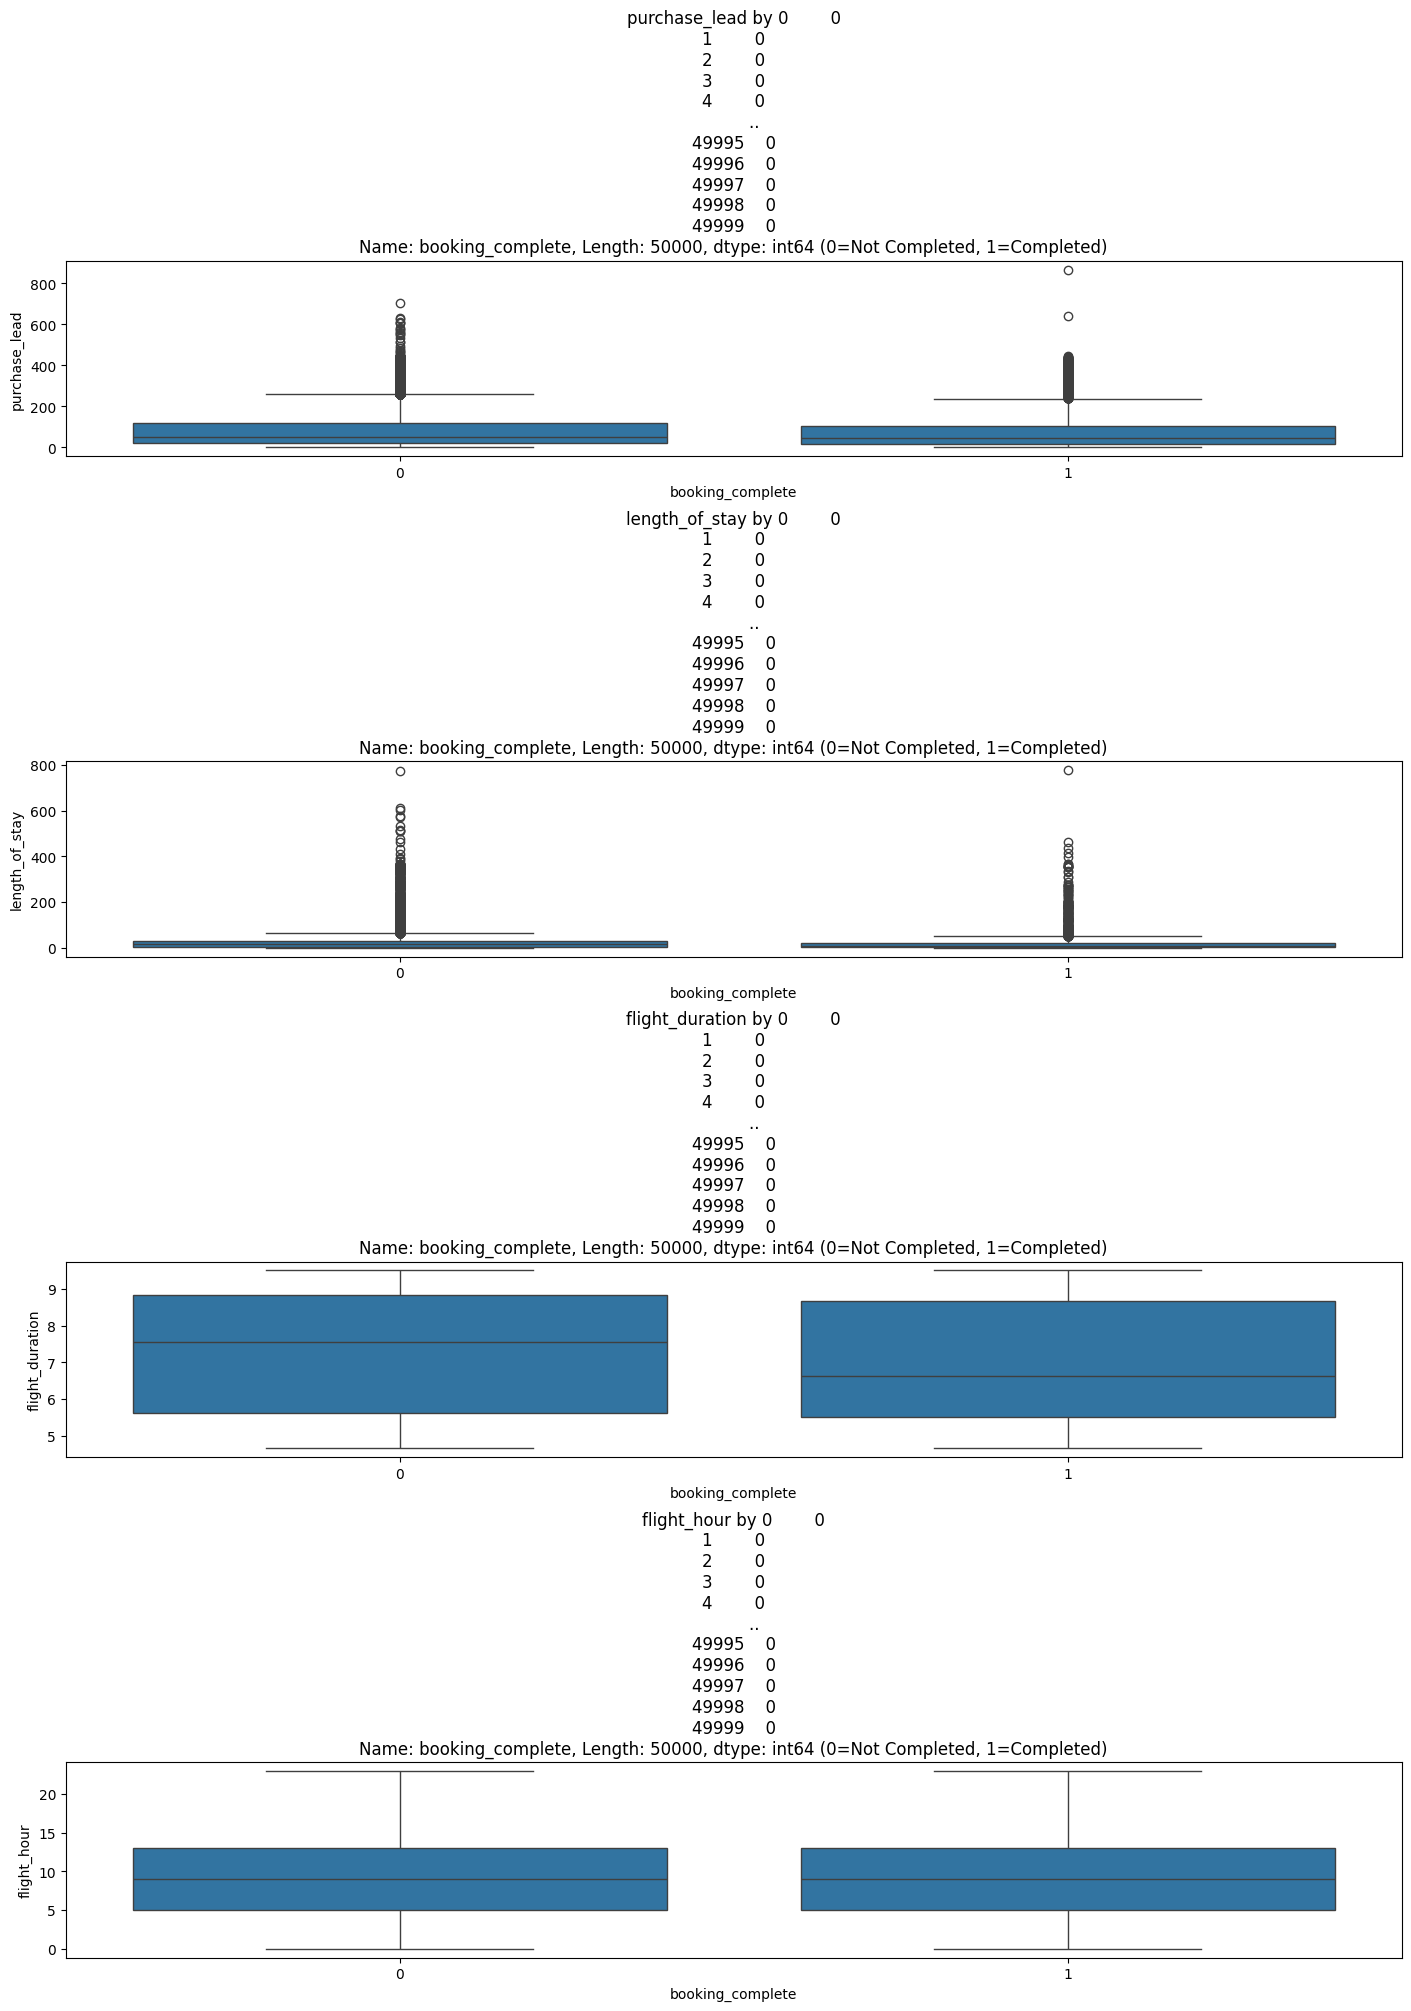

Columns being plotted: ['purchase_lead', 'length_of_stay', 'flight_duration', 'flight_hour']


In [13]:
cols_target=[c for c in numeric_cols if c in df.columns]
n=len(cols_target)
fig,axes=plt.subplots(nrows=n,ncols=1,figsize=(14,5*n),constrained_layout=True)
if n == 1:
    axes = [axes] 
for ax, col in zip(axes, cols_target):
    sns.boxplot(data=df, x=target, y=col, ax=ax)
    ax.set_title(f"{col} by {target} (0=Not Completed, 1=Completed)")
    ax.set_xlabel("booking_complete")
    ax.set_ylabel(col)
plt.show()
print("Columns being plotted:", cols_target)


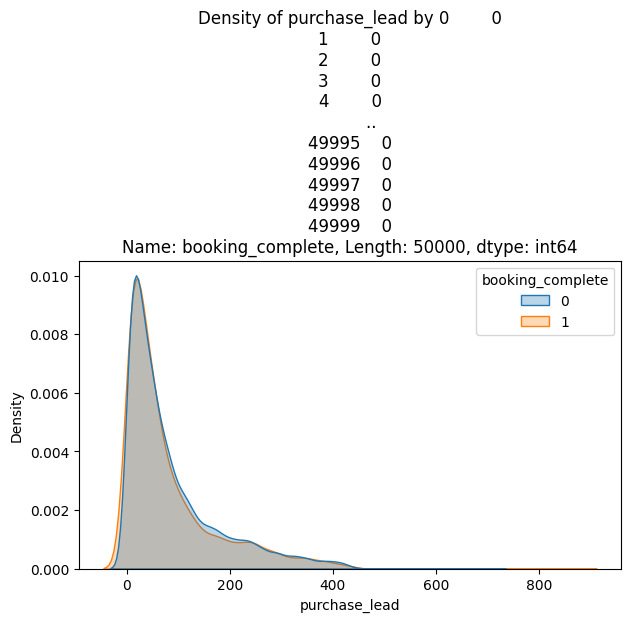

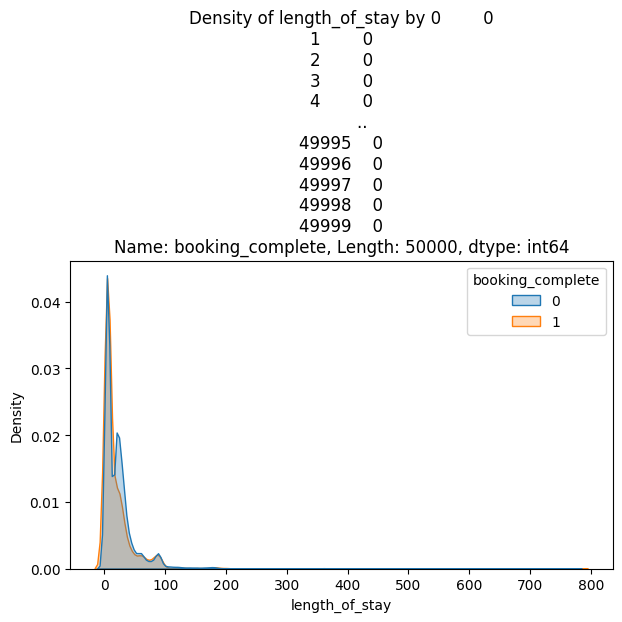

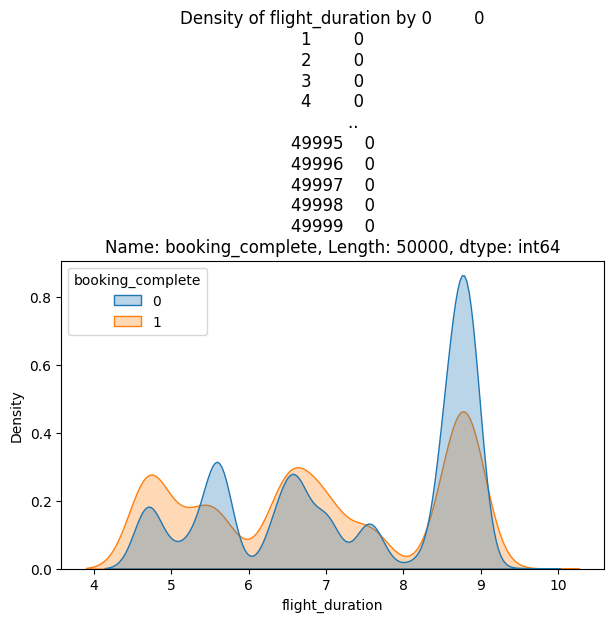

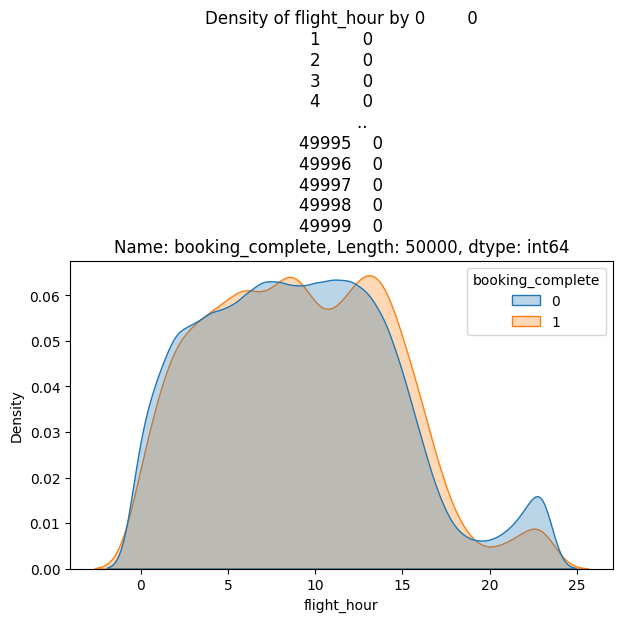

In [14]:
for col in cols_target:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df, x=col, hue=target, common_norm=False, fill=True, alpha=0.3)
    plt.title(f"Density of {col} by {target}")
    plt.xlabel(col)
    plt.show()


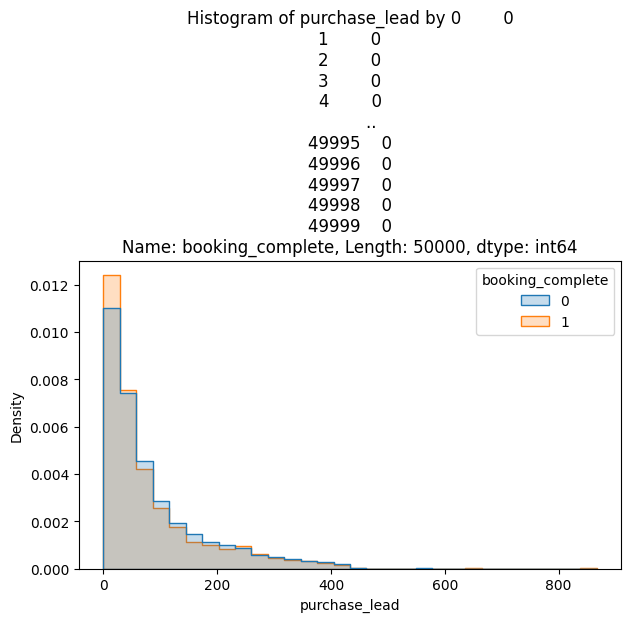

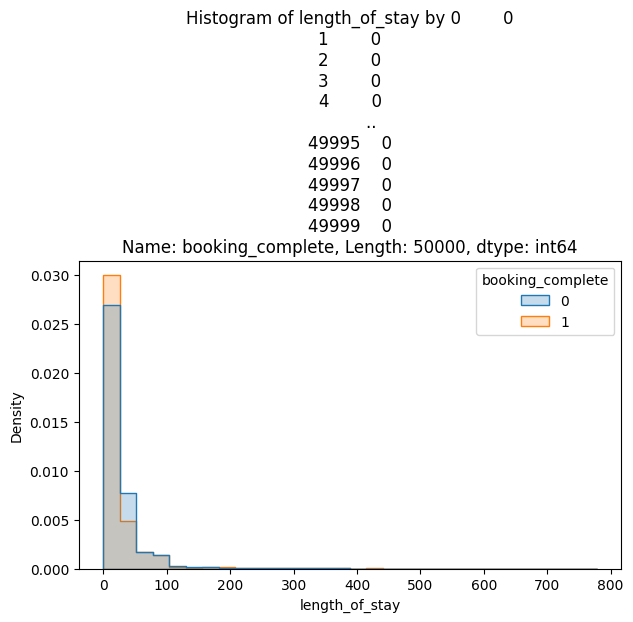

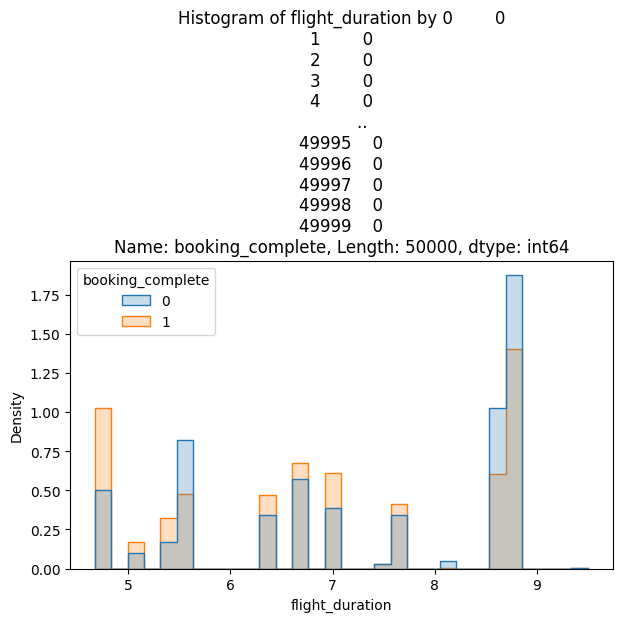

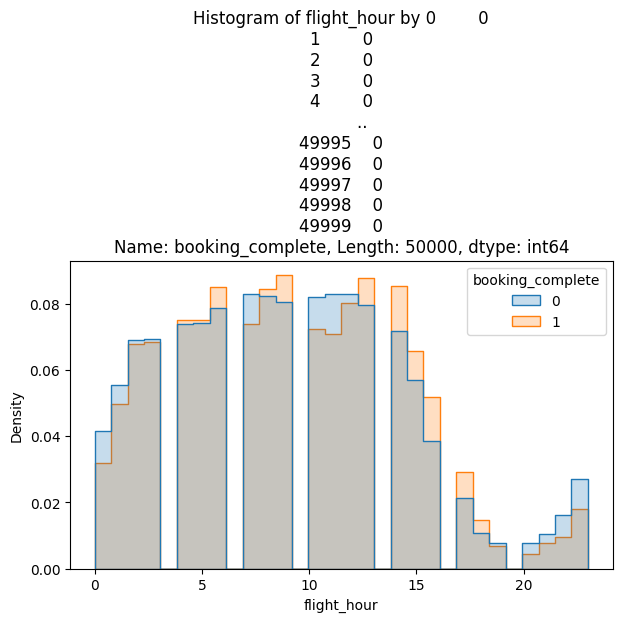

In [15]:
for col in cols_target:
    plt.figure(figsize=(7,4))
    sns.histplot(data=df, x=col, hue=target, element="step", stat="density", common_norm=False, bins=30)
    plt.title(f"Histogram of {col} by {target}")
    plt.xlabel(col)
    plt.show()


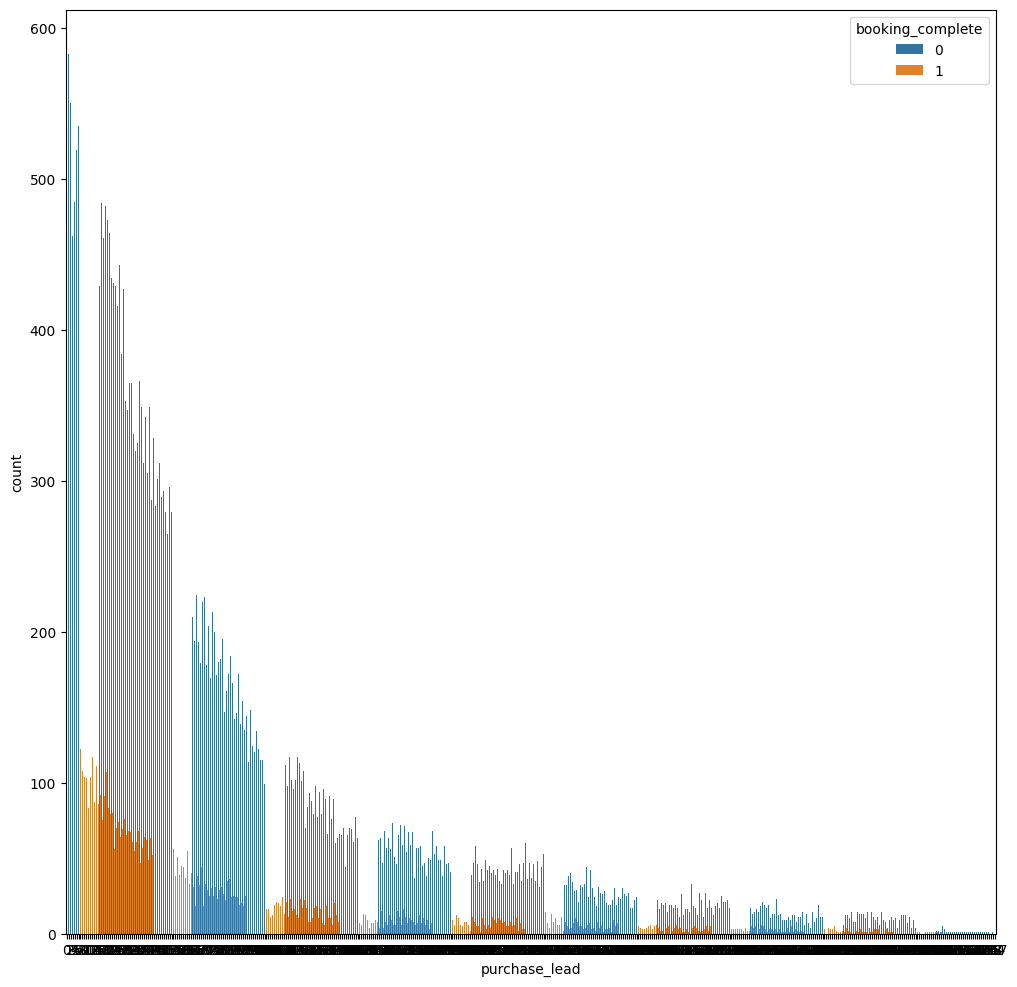

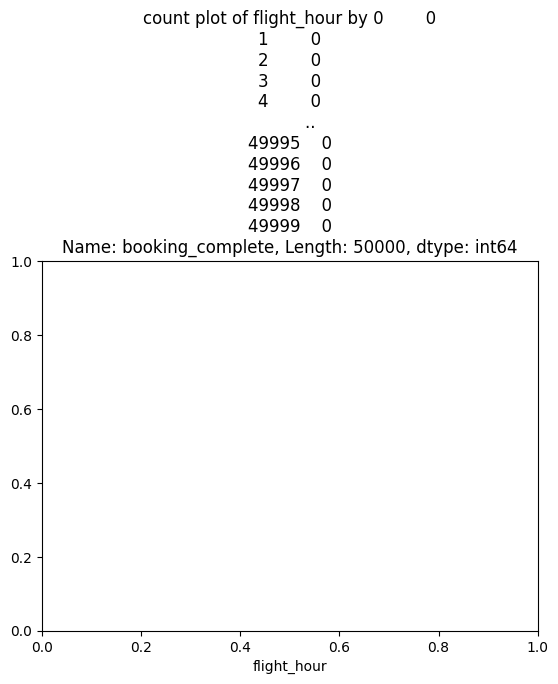

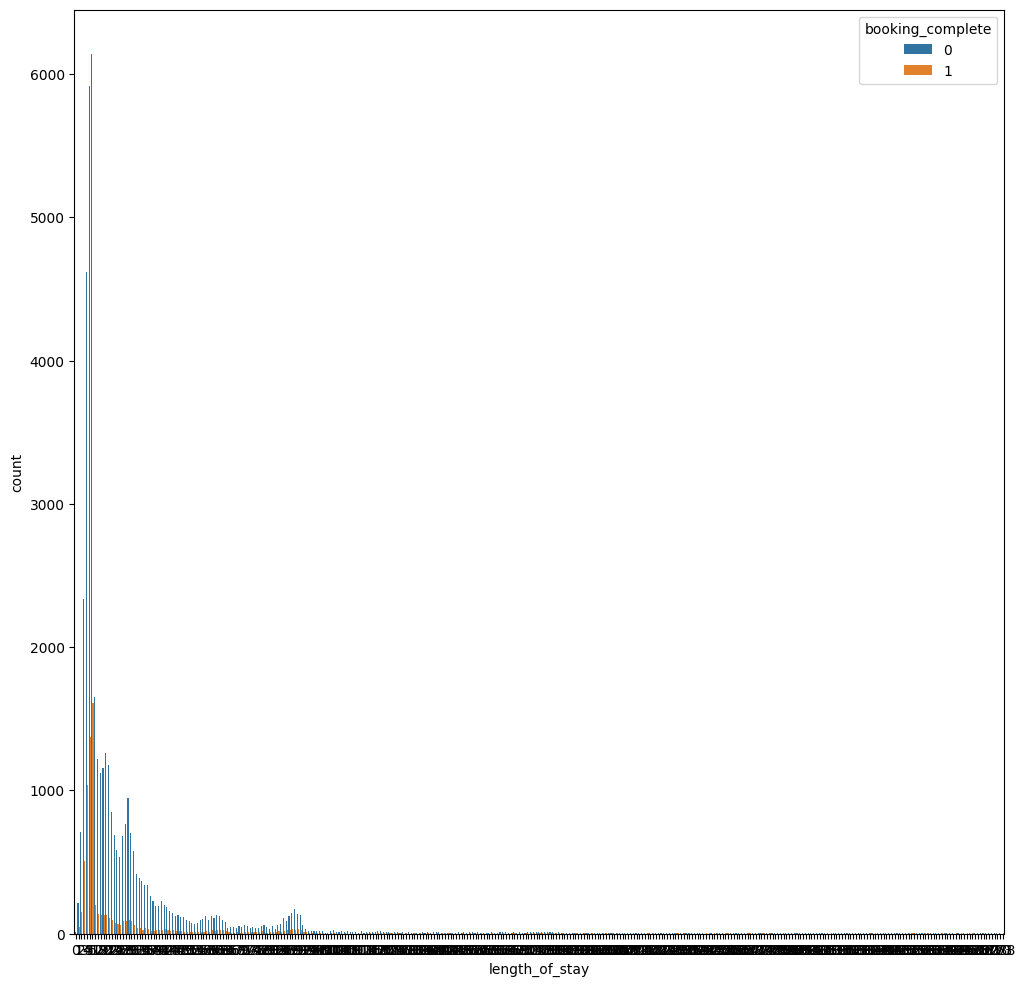

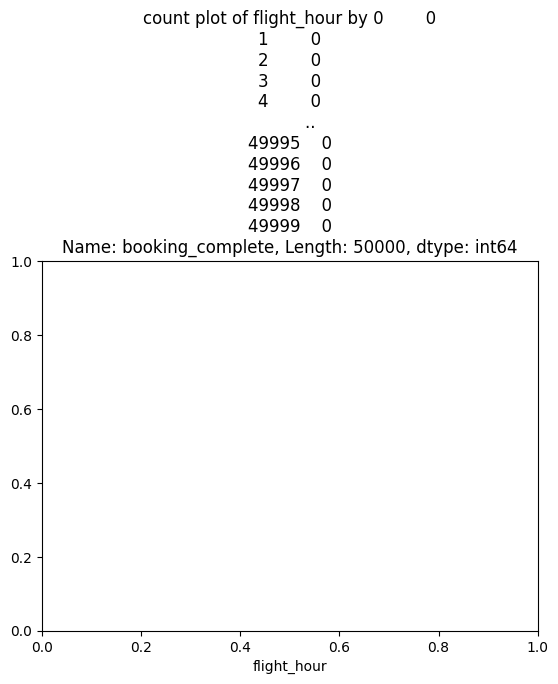

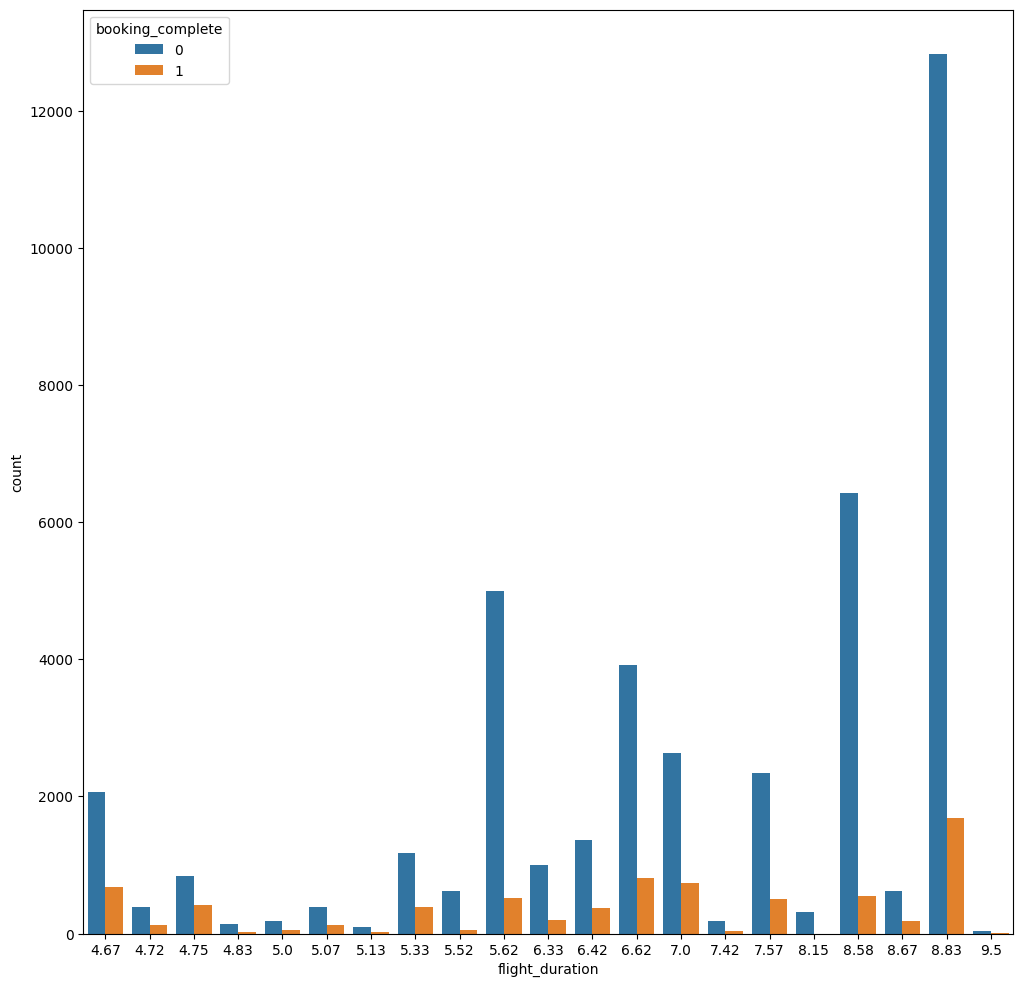

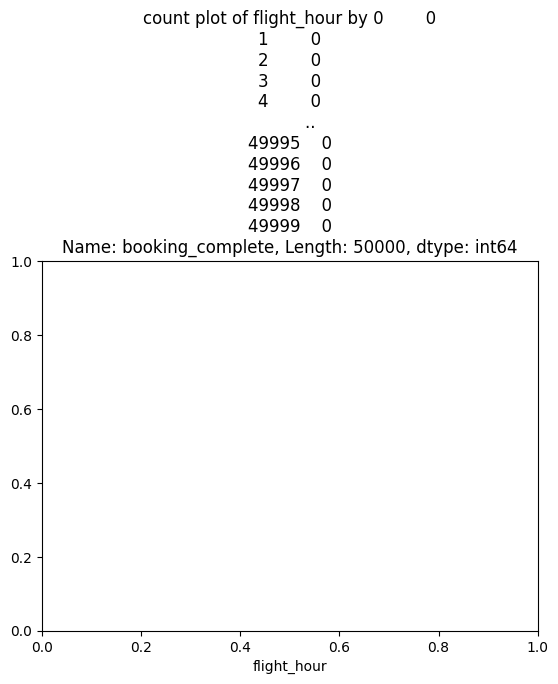

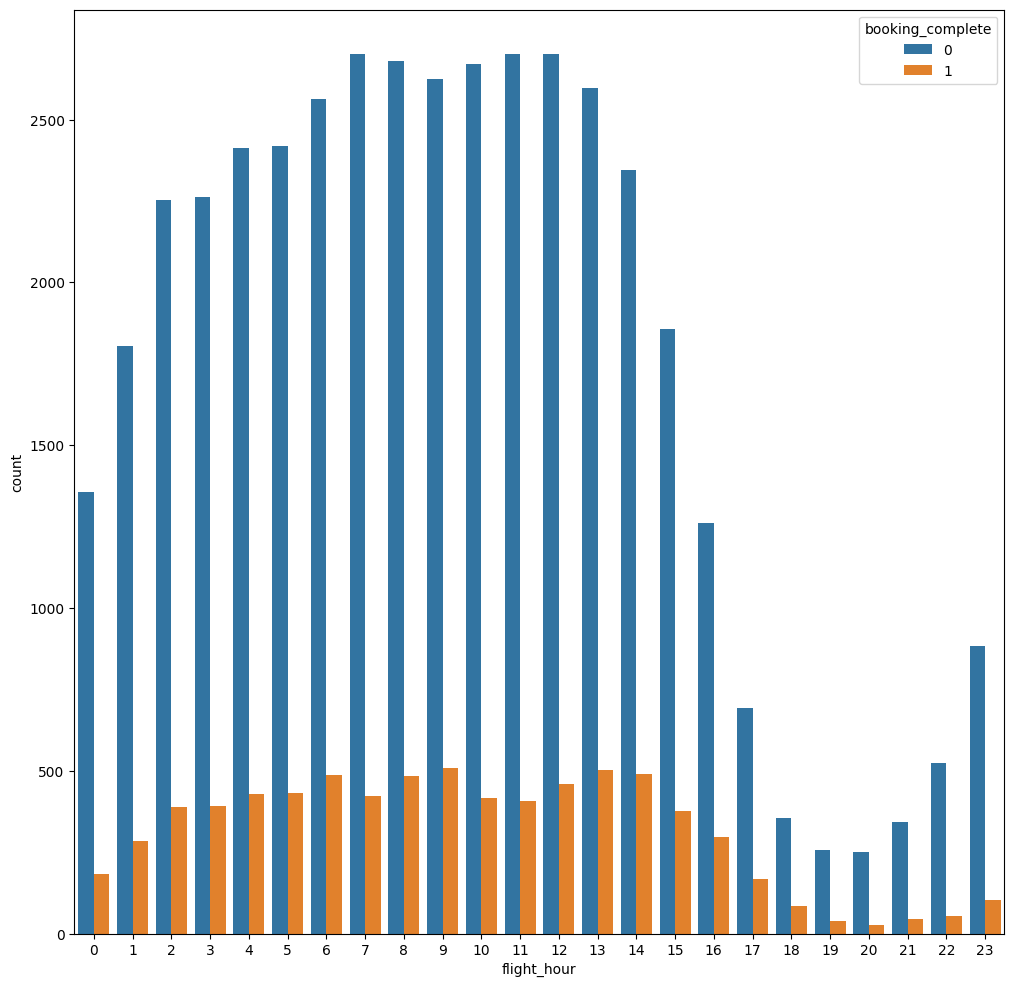

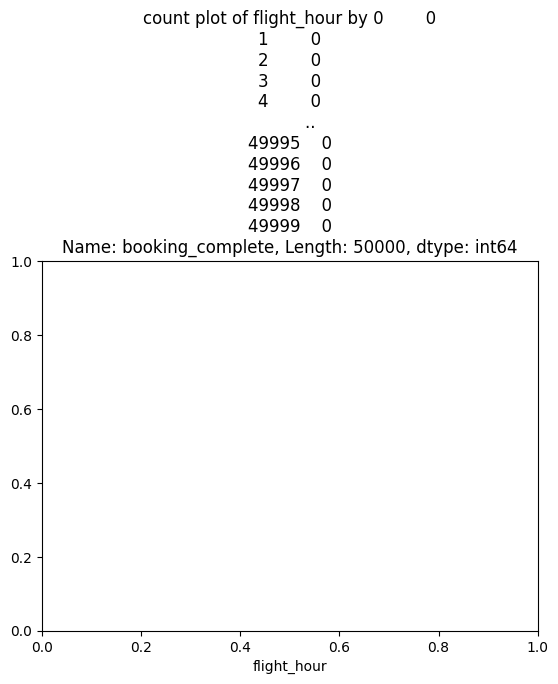

In [16]:
for cols in cols_target:
    plt.figure(figsize=(12,12))
    sns.countplot(data=df,x=cols,hue=target,stat="count")
    plt.show()
    plt.title(f"count plot of {col} by {target}")
    plt.xlabel(col)
    plt.show()

In [17]:

cat_cols=['sales_channel',
 'trip_type',
 'flight_day',
 'lead_bins',
 'stay_bin',
 'daypart',
 'flight_day_numerical',
 'wants_extra_baggage',
 'wants_preferred_seat',
 'wants_in_flight_meals']



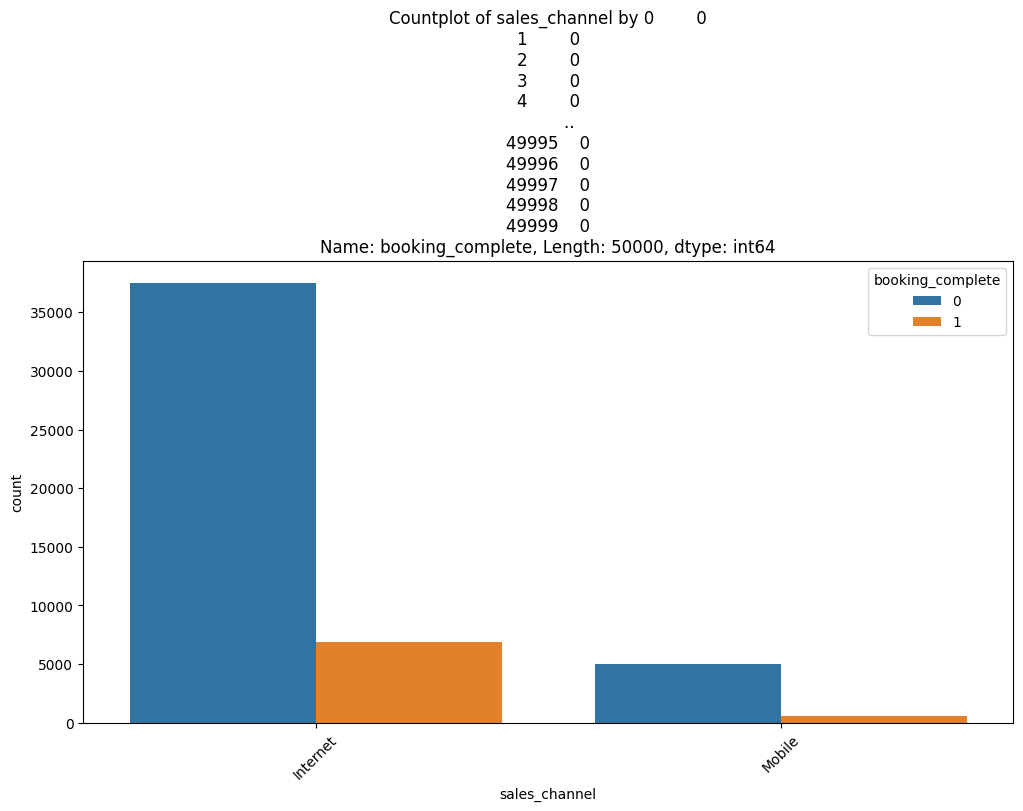

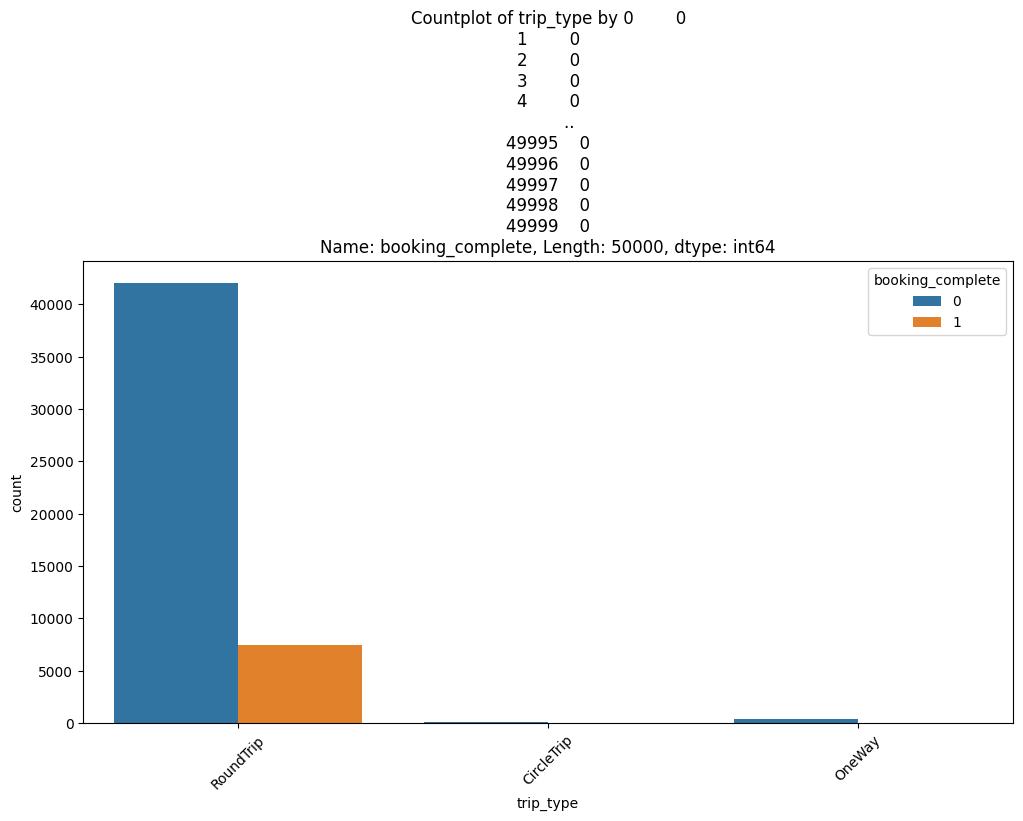

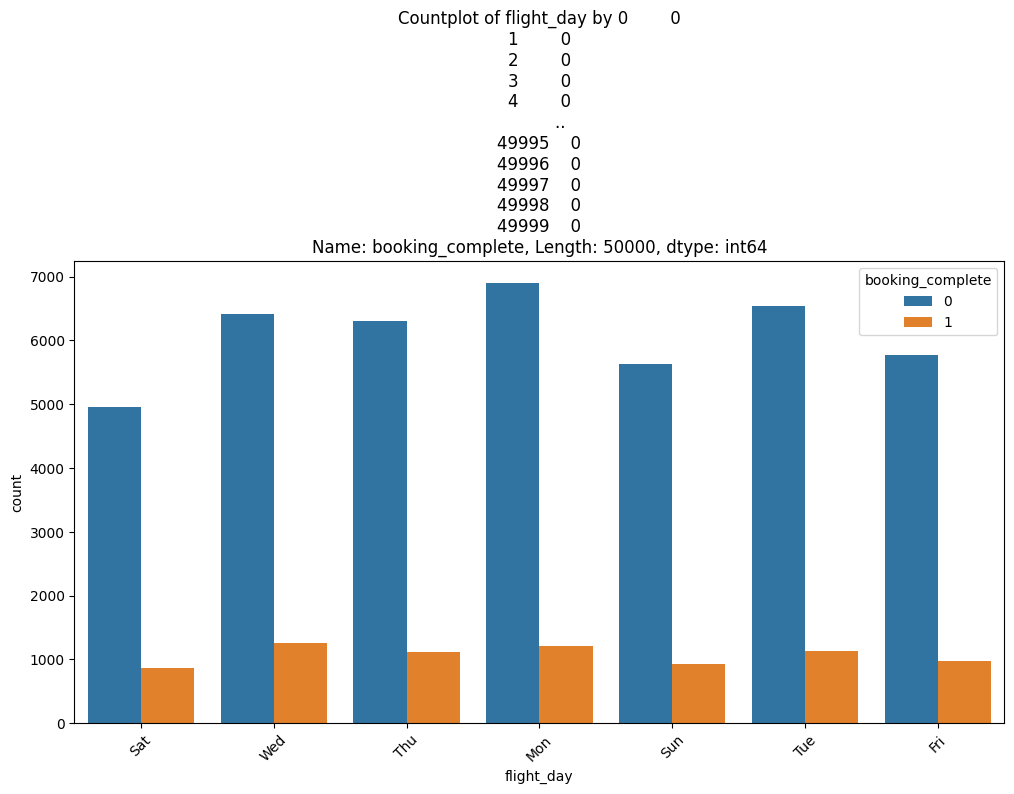

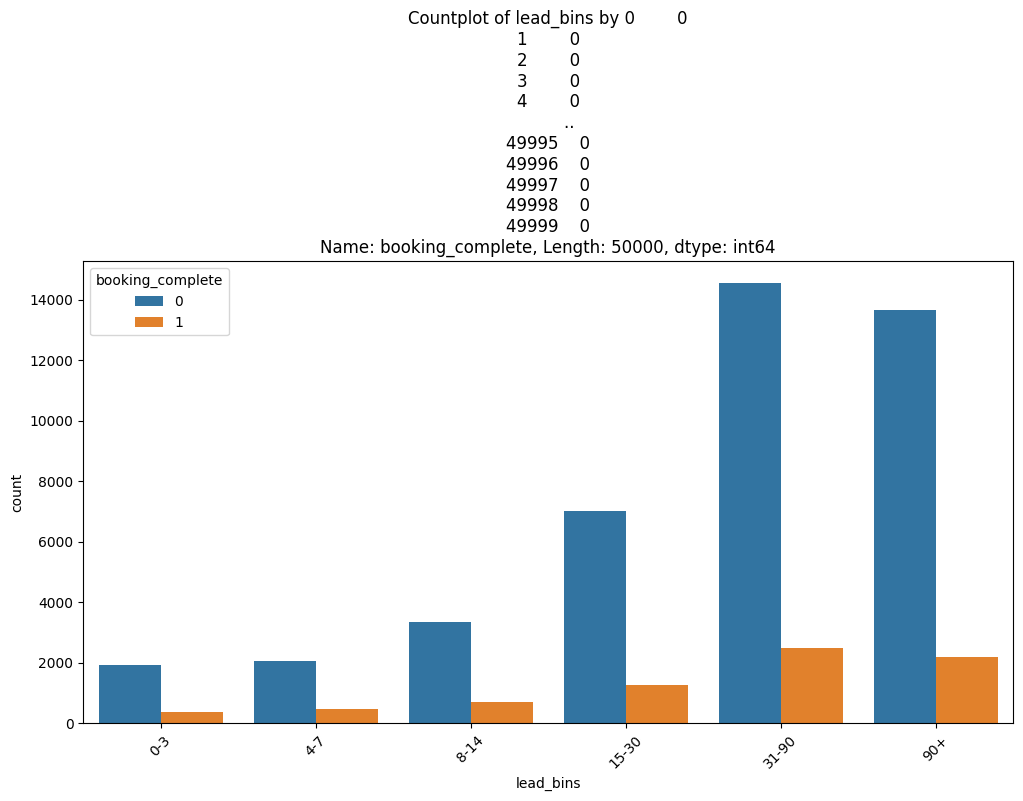

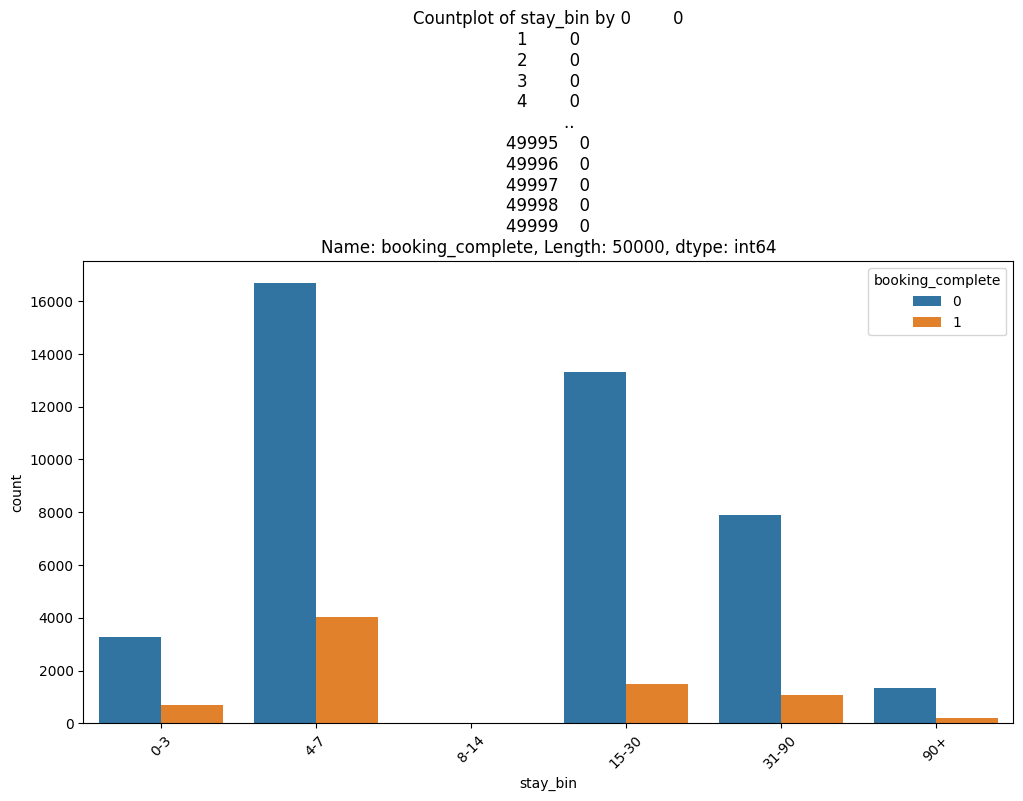

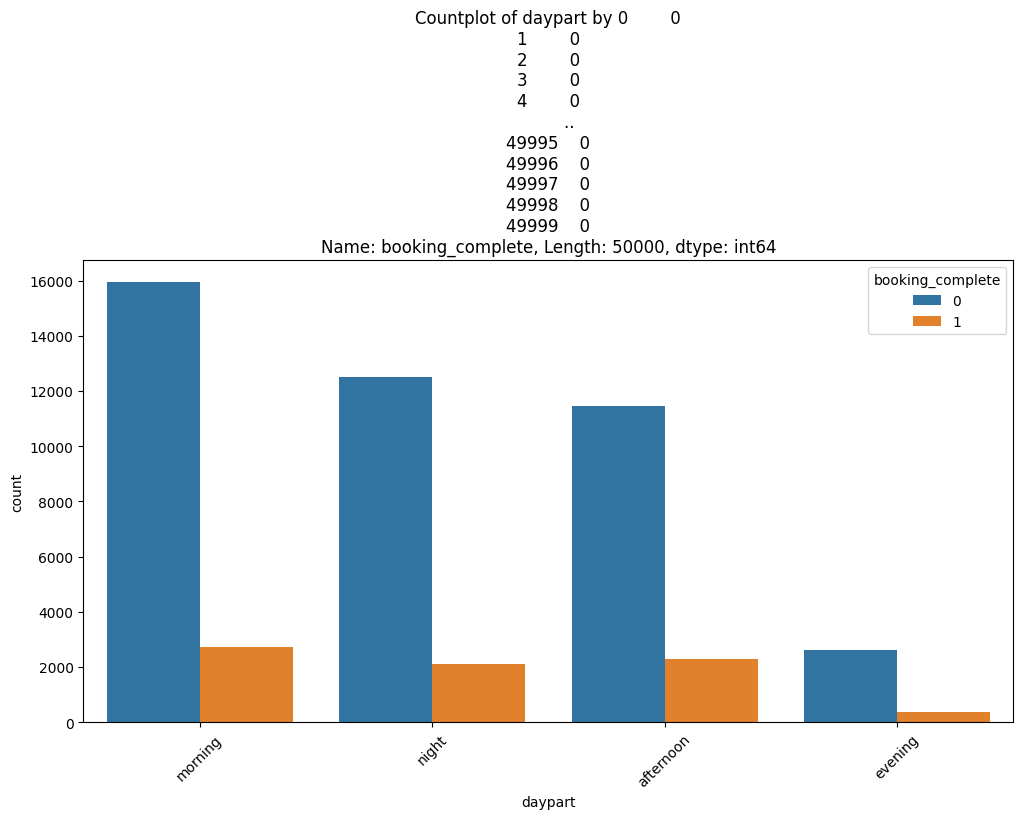

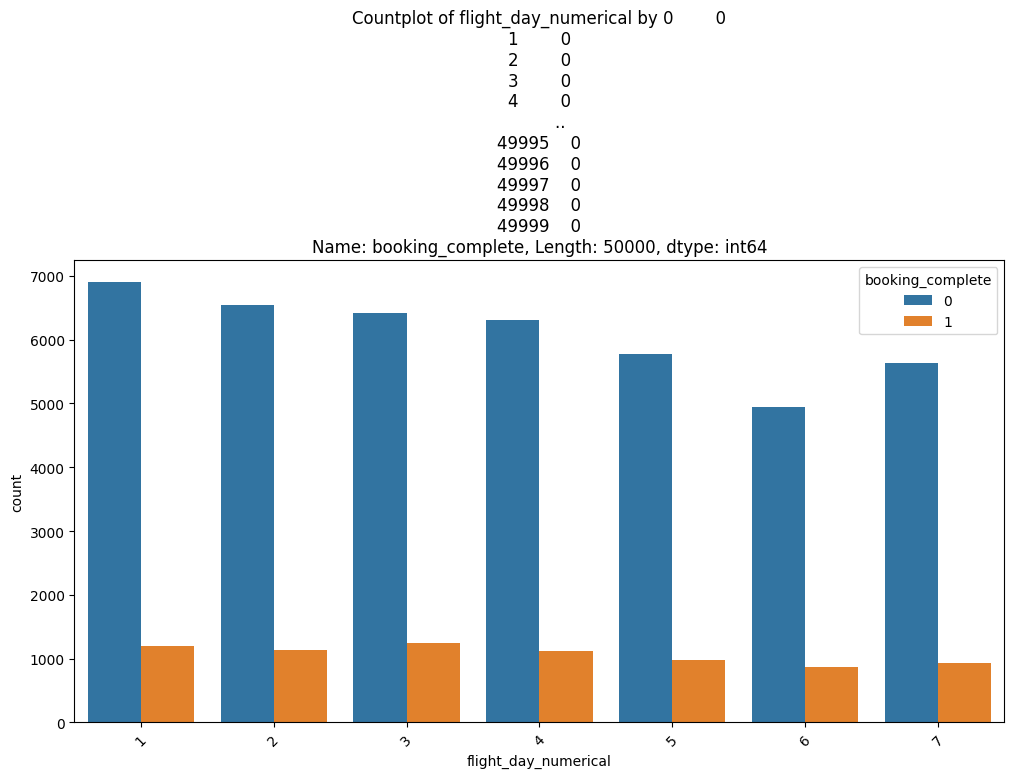

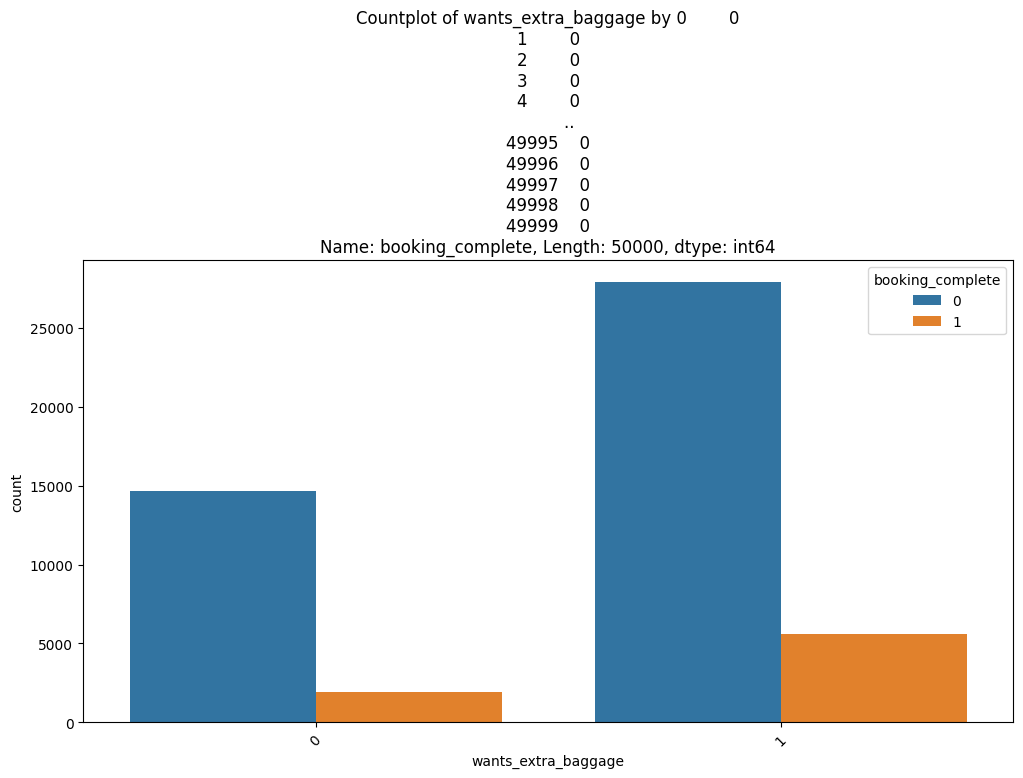

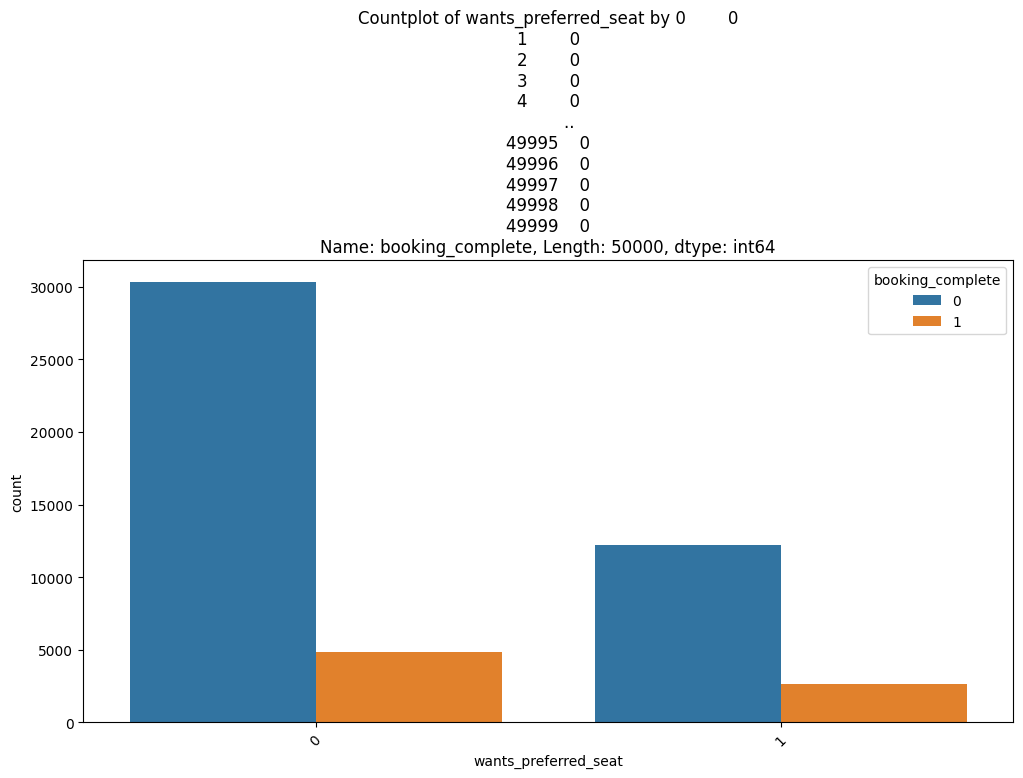

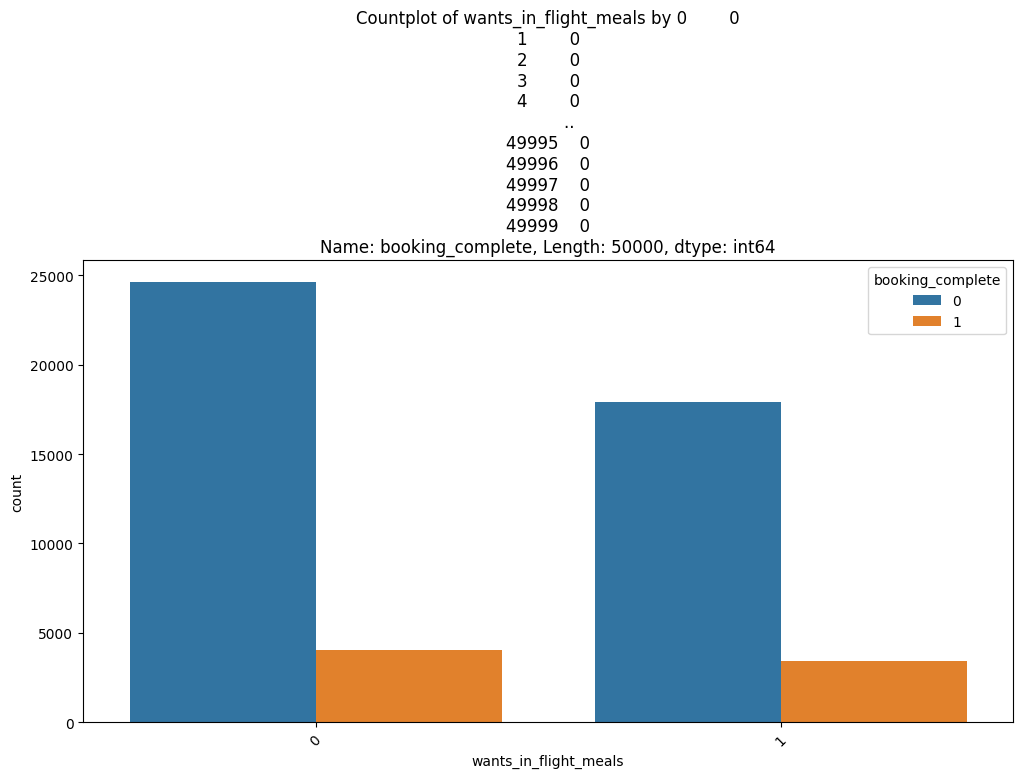

In [18]:
for cols in cat_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df,x=cols,hue=target,stat="count")
    plt.title(f"Countplot of {cols} by {target}")
    plt.xlabel(cols)
    plt.xticks(rotation=45,fontsize=10)
    plt.show()


In [19]:
_route=df['route'].value_counts().head(10).index
_booking_origin=df['booking_origin'].value_counts().head(10).index
df_route=df[df['route'].isin(_route)]
df_booking_origin=df[df['booking_origin'].isin(_booking_origin)]
fig = px.bar(df_booking_origin, x='booking_origin', y='booking_complete')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()
fig2=px.bar(df_route,x=df_route['route'],y='booking_complete')
fig2.update_layout(xaxis={'categoryorder':'total descending'})
fig2.update_xaxes(tickangle=45)
fig2.show()

In [20]:
import pandas as pd
import plotly.express as px

# Fix: Explicitly set target as string column name
target = 'booking_complete'

def completion_rate_table(df, col, target='booking_complete'):
    # Add debugging and validation
    print(f"target = {target}, type = {type(target)}")
    print(f"df columns: {list(df.columns)}")
    
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found. Available: {list(df.columns)}")
    if target not in df.columns:
        raise KeyError(f"Target '{target}' not found. Available: {list(df.columns)}")
    
    out = (df.groupby(col, dropna=False)[target]
             .mean()
             .rename('completion_rate')
             .to_frame())
    out['count'] = df[col].value_counts().reindex(out.index)
    return (out * 100).round(2).reset_index()

# Top 10 booking_origin by frequency  
top_routes = df['route'].value_counts().head(10).index
df_booking_routes = df[df['route'].isin(top_routes)]

# Now this should work:
rates = completion_rate_table(df_booking_routes, 'route', target)

fig = px.bar(rates, x='route', y='completion_rate',
             hover_data=['count'], text='completion_rate')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(xaxis={'categoryorder': 'total descending'},
                  yaxis_title='Completion rate (%)',
                  title='Completion Rate by routes (top 10 by volume)')
fig.show()


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


In [21]:
import pandas as pd
import plotly.express as px

# Fix: Explicitly set target as string column name
target = 'booking_complete'

def completion_rate_table(df, col, target='booking_complete'):
    # Add debugging and validation
    print(f"target = {target}, type = {type(target)}")
    print(f"df columns: {list(df.columns)}")
    
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found. Available: {list(df.columns)}")
    if target not in df.columns:
        raise KeyError(f"Target '{target}' not found. Available: {list(df.columns)}")
    
    out = (df.groupby(col, dropna=False)[target]
             .mean()
             .rename('completion_rate')
             .to_frame())
   
    out['count'] = df[col].value_counts().reindex(out.index)
    display(out)
    return (out * 100).round(2).reset_index()

# Top 10 booking_origin by frequency  
for cols in cat_cols:
    top_origins = df['booking_origin'].value_counts().head(10).index
    df_booking_origin = df[df['booking_origin'].isin(top_origins)]

    # Now this should work:
    rates = completion_rate_table(df, cols, target)

    fig = px.bar(rates, x=cols, y='completion_rate',
                hover_data=['count'], text='completion_rate')
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    fig.update_layout(xaxis={'categoryorder': 'total descending'},
                    yaxis_title='Completion rate (%)',
                    title='Completion Rate by {cols} (top 10 by volume)')
    fig.show()


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
sales_channel,,
Internet,0.154770,44382
Mobile,0.108402,5618


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
trip_type,,
CircleTrip,0.043103,116
OneWay,0.051680,387
RoundTrip,0.150575,49497


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
flight_day,,
Fri,0.145393,6761
Mon,0.148605,8102
Sat,0.148142,5812
Sun,0.141440,6554
Thu,0.151131,7424
Tue,0.147139,7673
Wed,0.163148,7674


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


C:\Users\nikhi\AppData\Local\Temp\ipykernel_21336\3972821795.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,completion_rate,count
lead_bins,,
0-3,0.164276,2301
4-7,0.181927,2512
8-14,0.174666,4042
15-30,0.154273,8284
31-90,0.145695,17015
90+,0.137574,15846


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


C:\Users\nikhi\AppData\Local\Temp\ipykernel_21336\3972821795.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,completion_rate,count
stay_bin,,
0-3,0.178365,3975
4-7,0.194318,20698
8-14,NaN,0
15-30,0.100958,14828
31-90,0.118487,8963
90+,0.122396,1536


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
daypart,,
afternoon,0.166703,13749
evening,0.118421,2964
morning,0.145972,18668
night,0.144333,14619


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
flight_day_numerical,,
1,0.148605,8102
2,0.147139,7673
3,0.163148,7674
4,0.151131,7424
5,0.145393,6761
6,0.148142,5812
7,0.141440,6554


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
wants_extra_baggage,,
0,0.115029,16561
1,0.166662,33439


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
wants_preferred_seat,,
0,0.137944,35152
1,0.177061,14848


target = booking_complete, type = <class 'str'>
df columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'flight_day_numerical', 'lead_bins', 'stay_bin', 'daypart']


,completion_rate,count
wants_in_flight_meals,,
0,0.141396,28643
1,0.160509,21357


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   num_passengers         50000 non-null  int64   
 1   sales_channel          50000 non-null  object  
 2   trip_type              50000 non-null  object  
 3   purchase_lead          50000 non-null  int64   
 4   length_of_stay         50000 non-null  int64   
 5   flight_hour            50000 non-null  int64   
 6   flight_day             50000 non-null  object  
 7   route                  50000 non-null  object  
 8   booking_origin         50000 non-null  object  
 9   wants_extra_baggage    50000 non-null  int64   
 10  wants_preferred_seat   50000 non-null  int64   
 11  wants_in_flight_meals  50000 non-null  int64   
 12  flight_duration        50000 non-null  float64 
 13  booking_complete       50000 non-null  int64   
 14  flight_day_numerical   50000 non-null 

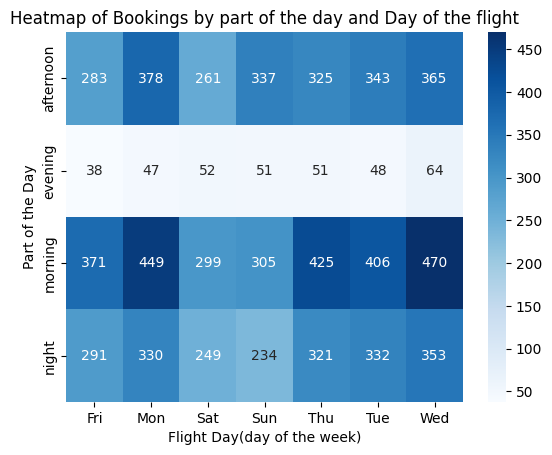

In [23]:
hour_day=df[df['booking_complete']==1].groupby(['daypart','flight_day'])['booking_complete'].sum().reset_index()
sort_hour_day=hour_day.sort_values(by='booking_complete',ascending=False).head(40)
pivot_table=sort_hour_day.pivot(index='daypart',columns='flight_day',values='booking_complete')
sns.heatmap(pivot_table,annot=True,fmt='g',cmap='Blues')
plt.title('Heatmap of Bookings by part of the day and Day of the flight')
plt.xlabel('Flight Day(day of the week)')
plt.ylabel('Part of the Day')
plt.show()


In [24]:
# top_origins=df['booking_origin'].value_counts().head(10).index
# top_routes=df['route'].value_counts().head(10).index
# df_booking_routes = df[df['route'].isin(top_routes)&df[df['booking_origin'].isin(top_origins)]
# ]

# sns.clustermap(x='booking_origin', y='route', hue='booking_complete', data=df_booking_routes, dodge=True, alpha=0.7)

In [25]:
# hour_day=df[df['booking_complete']==1].groupby(['route','booking_origin'])['booking_complete'].sum().reset_index()
# sort_hour_day=hour_day.sort_values(by='booking_complete',ascending=False).head(40)
# pivot_table=sort_hour_day.pivot(index='booking_origin',columns='route',values='booking_complete')
# sns.catplot(data=df, x='booking_origin', kind='count', col='route', col_wrap=3)
# plt.title('Heatmap of Bookings by part of the day and Day of the flight')
# plt.xlabel('Flight Day(day of the week)')
# plt.ylabel('Part of the Day')
# plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(contingency, chi2=None):
    if chi2 is None:
        chi2, *_ = chi2_contingency(contingency)
    n = contingency.to_numpy().sum()
    r, k = contingency.shape
    return np.sqrt((chi2 / n) / (min(r - 1, k - 1) or 1))  # guard for 1 in denominator

def chi2_with_v(df, feature, target='booking_complete'):
    contingency = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    v = cramers_v(contingency, chi2)
    return {'feature': feature, 'chi2': chi2, 'p_value': p, 'dof': dof, 'cramers_v': v, 'min_expected': ex.min()}

results = [chi2_with_v(df, f) for f in ['sales_channel','daypart','lead_bins','stay_bin']]
pd.DataFrame(results).sort_values('cramers_v', ascending=False)

def chi2_report(df, feature, target='booking_complete', top_k=None):
    s = df[feature].astype('object')
    if top_k and s.nunique() > top_k:
        keep = s.value_counts().head(top_k).index
        s = s.where(s.isin(keep), 'Other')

    contingency = pd.crosstab(s, df[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    v = cramers_v(contingency, chi2)

    rates = (df.groupby(s.name)[target].mean().mul(100).round(2)
             .rename('completion_rate_%')
             .to_frame()
             .assign(count=s.value_counts())
             .sort_values('completion_rate_%', ascending=False))

    return chi2, p, dof, v, ex.min(), contingency, rates
for f in ['sales_channel','daypart','lead_bins','stay_bin','trip_type','flight_day',
    'route','booking_origin','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals']:
    print(f"Feature: {f}")
    chi2, p, dof, v, min_exp, table, rates = chi2_report(df, f, top_k=10)
    print(f"  χ²={chi2:.2f}, p={p:.3g}, dof={dof}, V={v:.3f}, min_exp={min_exp:.1f}")
    display(table)
    display(rates)




83.93114914857576
5.123094421404519e-20
Feature: sales_channel
  χ²=83.93, p=5.12e-20, dof=1, V=0.041, min_exp=840.2


booking_complete,0,1
sales_channel,,
Internet,37513,6869
Mobile,5009,609


,completion_rate_%,count
sales_channel,,
Internet,15.48,44382
Mobile,10.84,5618


Feature: daypart
  χ²=59.39, p=7.92e-13, dof=3, V=0.034, min_exp=443.3


booking_complete,0,1
daypart,,
afternoon,11457,2292
evening,2613,351
morning,15943,2725
night,12509,2110


,completion_rate_%,count
daypart,,
afternoon,16.67,13749
morning,14.60,18668
night,14.43,14619
evening,11.84,2964


Feature: lead_bins
  χ²=65.98, p=7.01e-13, dof=5, V=0.036, min_exp=344.1


C:\Users\nikhi\AppData\Local\Temp\ipykernel_21336\3795665825.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



booking_complete,0,1
lead_bins,,
0-3,1923,378
15-30,7006,1278
31-90,14536,2479
4-7,2055,457
8-14,3336,706
90+,13666,2180


,completion_rate_%,count
lead_bins,,
4-7,18.19,2512
8-14,17.47,4042
0-3,16.43,2301
15-30,15.43,8284
31-90,14.57,17015
90+,13.76,15846


Feature: stay_bin
  χ²=704.26, p=4.16e-151, dof=4, V=0.119, min_exp=229.7


C:\Users\nikhi\AppData\Local\Temp\ipykernel_21336\3795665825.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



booking_complete,0,1
stay_bin,,
0-3,3266,709
15-30,13331,1497
31-90,7901,1062
4-7,16676,4022
90+,1348,188


,completion_rate_%,count
stay_bin,,
4-7,19.43,20698.0
0-3,17.84,3975.0
90+,12.24,1536.0
31-90,11.85,8963.0
15-30,10.10,14828.0
8-14,NaN,NaN


## Top 5  EDA insights and  Hypothese